In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
from torch.utils.data import DataLoader
from transformer_model import Transformer
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import torch
import time,os,json

### Load dataset, train-val splits

In [ ]:
with open("../data/img_text_comb_updated_v3.pkl", "rb") as f:
    data_pkl = pkl.load(f)

In [ ]:
df_text = pd.read_csv("../youcook2/reviewed_0812.csv")

In [7]:
def get_id(url):
    url_parts = url.split("?")

    # Extracting the query parameters part of the URL
    query_params = url_parts[1] if len(url_parts) > 1 else ""

    # Splitting the query parameters by "&" to separate individual key-value pairs
    query_params = query_params.split("&")

    # Extracting the video ID from the query parameters
    video_id = ""
    for param in query_params:
        if param.startswith("v="):
            video_id = param[2:]
        break
    return video_id

In [3]:
split_df = pd.read_csv("../data/train_val_split.csv")

In [4]:
train_url = split_df[split_df.Split == "train"]["VideoUrl"]
val_url = split_df[split_df.Split == "val"]["VideoUrl"]

In [8]:
train_id = list(map(get_id, train_url))
val_id = list(map(get_id, val_url))

In [9]:
train_data = {}
test_data = {}

In [10]:
for v_id in train_id:
    if v_id not in data_pkl.keys():
        continue
    else:
        train_data[v_id] = data_pkl[v_id]

5nh2CP22dgY
oJZUxU9szWA
so-RuJQY1d0
psXv6tX1GnA
Vy5ypC9_cOs
lBguj96fa5w


In [11]:
for v_id in val_id:
    if v_id not in data_pkl.keys():
        continue
    else:
        test_data[v_id] = data_pkl[v_id]

okvTq8gtr8c
_gG0As2y92g
btikV_DUoCM
-goI2-eJO1w


### Define dataloader class

In [42]:
class YouCookData(torch.utils.data.Dataset):
    def __init__(self, data, seq_len = 136):
        # Merge resnet feat + text --> S, D --> Pad till 136 --> Return inp + mask
        self.input = []
        self.mask = []
        self.labels = []
        i=0
        for vid_name in tqdm(data.keys()):
            txt_emb = data[vid_name]["text_emb(DistilBERT)"]
            img_emb = data[vid_name]["img_feat"]
            label = np.array(data[vid_name]["IsUsefulSentence"])
            if txt_emb.shape[0] !=  img_emb.shape[0]:
                print(vid_name)
                i += 1
                continue
            
            ## For text only model - comment below line
            concat_emb = np.concatenate((txt_emb, img_emb), axis=1)
#             concat_emb = txt_emb

            len_story = concat_emb.shape[0]
            if len_story < seq_len:
                padding = np.zeros((seq_len-len_story, concat_emb.shape[1]))
                concat_emb = np.concatenate((concat_emb, padding), axis=0)
                label = np.concatenate((label, -1*np.ones(seq_len-len_story)))
                
            mask = np.zeros(seq_len)
            mask[:len_story] = 1
            self.input.append(concat_emb)
            self.mask.append(mask)
            self.labels.append(label)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]), torch.from_numpy(self.mask[idx]), torch.from_numpy(self.labels[idx])

    def __len__(self):
        return len(self.labels)

In [43]:
len(train_data.keys()), len(test_data.keys())

(247, 95)

In [44]:
train_dataset = YouCookData(train_data)
test_dataset = YouCookData(test_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 2734.10it/s]


In [45]:
batchsize=64
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

### Define train/eval methods

In [61]:
def train_one_epoch(model: torch.nn.Module, training_data_loader: DataLoader, optimizer: torch.optim.Optimizer, logging_frequency: int, testing_data_loader: DataLoader, logger: dict):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0
    logging_loss = 0
    start_time = time.time()
    mini_start_time = time.time()
    for step, batch in enumerate(training_data_loader):
        inp, mask, label = batch
        inp = inp.float().cuda()
        mask = mask.long().cuda()
        label = label.long().cuda()
        
        outputs = model(inp, mask, label)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        logging_loss += loss.item()


    print("Running Evaluation Step")
    eval_f1, eval_loss = evaluate(model, testing_data_loader)
    
    print(f"Evaluation Loss, F1: {eval_loss}, {eval_f1}")
    return epoch_loss / len(training_data_loader), eval_loss, eval_f1


def evaluate(model: torch.nn.Module, test_data_loader: DataLoader):
    model.eval()
    eval_loss = 0
    correct_predictions = {i: 0 for i in range(2)}
    total_predictions = {i: 0 for i in range(2)}
    start_time = time.time()
    targets = []
    prediction_list= []
    with torch.no_grad():
        for step, batch in enumerate(test_data_loader):
            inp, mask, label = batch
            inp = inp.float().cuda()
            mask = mask.long().cuda()
            label = label.long().cuda()
            outputs = model(inp, mask, label)
            loss = outputs[0]
            eval_loss += loss.item()
            predictions = np.argmax(outputs[1].detach().cpu().numpy(), axis=2)
            
            target = label.cpu().numpy()
            target_mask = target != -1
            
            target = target[target_mask]
            predictions = predictions[target_mask]
            
            targets.extend(list(target))
            prediction_list.extend(list(predictions))
    
    targets = np.array(targets)
    prediction_list = np.array(prediction_list)

#     print(classification_report(targets, prediction_list))
    
    f1 = f1_score(targets, prediction_list, labels=[1])
    model.train()
    return f1,  eval_loss / len(test_data_loader)

### Define logging method

In [47]:
def get_logger(model):
    logger = dict()
    logger['train_losses'] = []
    logger['eval_f1'] = []
    logger['eval_losses'] = []
    return logger

In [48]:
def save_logs(dictionary, log_dir, exp_id):
    log_dir = os.path.join(log_dir, exp_id)
    os.makedirs(log_dir, exist_ok=True)
    # Log arguments
    with open(os.path.join(log_dir, "args.json"), "w") as f:
        json.dump(dictionary, f, indent=2)


### Training loop

In [ ]:
learning_rate = 1e-4
num_epochs = 50
logging_frequency = 10
model = Transformer(embed_dim=786, num_heads=4, num_layers=4, block='postnorm', dropout=0.3)
model.cuda()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-8)    
logger = get_logger(model)
best_f1=0
best_epoch = 0

base_path = "../models/attention_keyclip_distilbert_multimodal/"
if not os.path.exists(base_path):
    os.makedirs(base_path)
for i in range(num_epochs):
    train_loss, val_loss, val_f1 = train_one_epoch(model, train_loader, optimizer, logging_frequency, test_loader, logger)
    print("Train loss: {}".format(train_loss))
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = i
        torch.save(model.state_dict(),os.path.join(base_path,"best_model.pkl"))
        
    logger['train_losses'].append(train_loss)
    logger['eval_losses'].append(val_loss)
    logger['eval_f1'].append(val_f1)
    save_logs(logger, "../logs/attention_keyclip_distilbert_multimodal", "1")
    

### Plotting

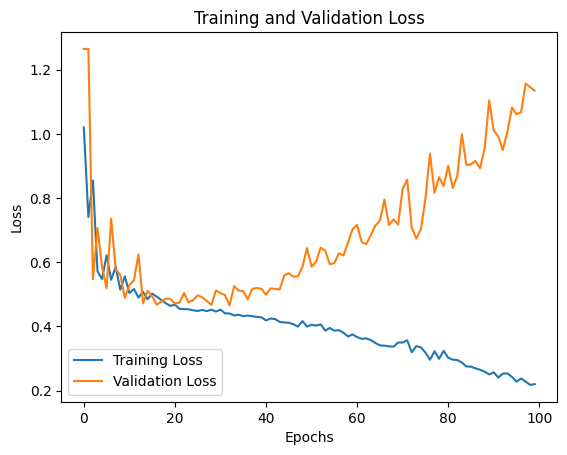

In [52]:
epochs = range(num_epochs)
 
# Plot and label the training and validation loss values
plt.plot(epochs, logger["train_losses"], label='Training Loss')
plt.plot(epochs, logger['eval_losses'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

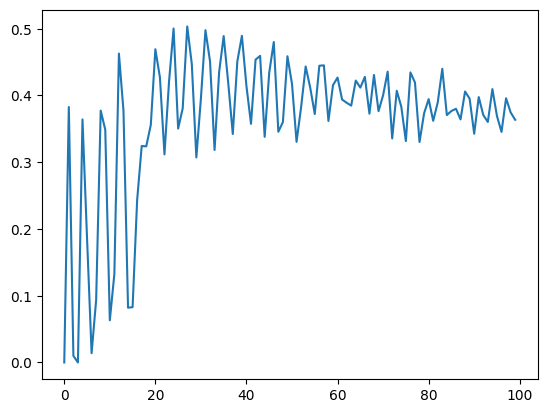

In [53]:
plt.figure()
plt.plot(epochs, logger["eval_f1"], label='Eval f1')
plt.show()

In [54]:
print(best_f1)

0.503345342254246


In [ ]:
model.load_state_dict(torch.load("../models/attention_keyclip_distilbert/best_model.pkl",map_location="cpu"))
a,b = evaluate(model, test_loader)